### Question 23

#### Load Cora Dataset

In [59]:
#!pip install torch_geometric ##### For Google Colab only

In [60]:
import numpy as np
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt

In [61]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='tmp/Cora', name='Cora')

In [62]:
dataset.num_classes

7

In [63]:
dataset.num_node_features

1433

#### Confirm Distributions and Sizes of Train-Val-Test Splits

In [64]:
train_inds = np.where(dataset.train_mask.detach() == True)
val_inds = np.where(dataset.val_mask.detach() == True)
test_inds = np.where(dataset.test_mask.detach() == True)

train_labels = dataset.y.detach().numpy()[train_inds]
val_labels = dataset.y.detach().numpy()[val_inds]
test_labels = dataset.y.detach().numpy()[test_inds]


Text(0.5, 1.0, 'Frequency Counts of Cora Training Dataset')

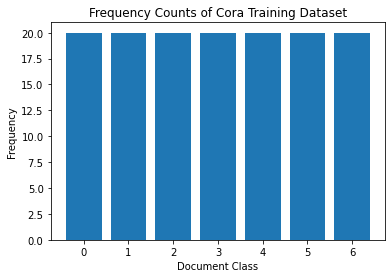

In [65]:
plt.bar(np.unique(train_labels, return_counts=True)[0], height=np.unique(train_labels, return_counts=True)[1])
plt.xlabel('Document Class')
plt.ylabel('Frequency')
plt.title('Frequency Counts of Cora Training Dataset')

In [66]:
np.unique(val_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([ 61,  36,  78, 158,  81,  57,  29]))

Text(0.5, 1.0, 'Frequency Counts of Cora Validation Dataset')

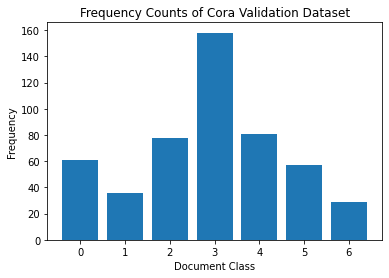

In [67]:
plt.bar(np.unique(val_labels, return_counts=True)[0], height=np.unique(val_labels, return_counts=True)[1])
plt.xlabel('Document Class')
plt.ylabel('Frequency')
plt.title('Frequency Counts of Cora Validation Dataset')

Text(0.5, 1.0, 'Frequency Counts of Cora Testing Dataset')

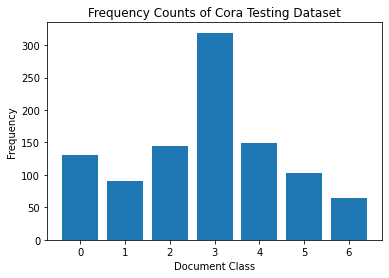

In [68]:
plt.bar(np.unique(test_labels, return_counts=True)[0], height=np.unique(test_labels, return_counts=True)[1])
plt.xlabel('Document Class')
plt.ylabel('Frequency')
plt.title('Frequency Counts of Cora Testing Dataset')

#### Create GCNConv Network

In [69]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.norm import BatchNorm

##### Tune this as needed
hidden_layer_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_layer_size)
        self.conv2 = GCNConv(hidden_layer_size, dataset.num_classes)

        self.relu = F.relu
        self.dropout = F.dropout
        self.log_softmax = F.log_softmax

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x, 0.5)
        x = self.conv2(x, edge_index)

        return self.log_softmax(x, dim=1)


class DeepGCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_layer_size)
        self.conv2 = GCNConv(hidden_layer_size, hidden_layer_size)
        self.conv3 = GCNConv(hidden_layer_size, dataset.num_classes)

        #self.batchnorm = BatchNorm(hidden_layer_size) ##### Experimental BatchNorm

        self.relu = F.relu
        self.dropout = F.dropout
        self.log_softmax = F.log_softmax

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        #x = self.batchnorm(x) ##### Experimental BatchNorm
        x = self.dropout(x, 0.5)

        x = self.conv2(x, edge_index)
        x = self.relu(x)
        #x = self.batchnorm(x) ##### Experimental BatchNorm
        x = self.dropout(x, 0.5)

        x = self.conv3(x, edge_index)

        return self.log_softmax(x, dim=1)
    


#### Check for GPU

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [71]:
vars(dataset)

{'name': 'Cora',
 'split': 'public',
 'root': 'tmp/Cora',
 'transform': None,
 'pre_transform': None,
 'pre_filter': None,
 'log': True,
 '_indices': None,
 '_data': Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708]),
 'slices': None,
 '_data_list': None}

In [72]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [73]:
type(dataset[0])

torch_geometric.data.data.Data

In [74]:
#model = GCN().to(device) # 2-Layer NN
model = DeepGCN().to(device) # 3-Layer NN
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [75]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [76]:
from torch_geometric.loader import DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [77]:
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [78]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import random
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

n_epochs = 200
pbar = tqdm(range(n_epochs))

train_loss_hist = []
val_loss_hist = []

train_acc_hist = []
val_acc_hist = []


for epoch in pbar:
    model.train()
    for batch in loader:
        optimizer.zero_grad()
        out = model(batch.to(device))
        loss = F.nll_loss(out[batch.train_mask], batch.y[batch.train_mask])

        train_loss_hist.append(loss.item()) # Store training loss

        loss.backward()
        optimizer.step()

    model.eval()
    
    ##### ========== Save training accuracy ========== #####
    y_batch_pred_train = []
    y_batch_true_train = []
    with torch.no_grad():
        for batch in loader:
            train_pred = model(batch.to(device)).argmax(dim=1)
            y_batch_pred_train.append(train_pred[data.train_mask].detach().cpu().numpy())
            y_batch_true_train.append(batch.y[data.train_mask].detach().cpu().numpy())

    
    batch_train_acc = accuracy_score(y_batch_true_train[0], y_batch_pred_train[0])
    train_acc_hist.append(batch_train_acc)
    ##### ============================================ #####


    ##### ========== Save validation accuracy ========== #####
    y_batch_pred_val = []
    y_batch_true_val = []
    with torch.no_grad():
        for batch in loader:
            val_pred = model(batch.to(device)).argmax(dim=1)
            val_loss = F.nll_loss(out[batch.val_mask], batch.y[batch.val_mask])
            val_loss_hist.append(val_loss.item()) ##### Save validation loss
            y_batch_pred_val.append(val_pred[data.val_mask].detach().cpu().numpy())
            y_batch_true_val.append(batch.y[data.val_mask].detach().cpu().numpy())


    batch_val_acc = accuracy_score(y_batch_true_val[0], y_batch_pred_val[0])
    val_acc_hist.append(batch_val_acc)
    ##### ============================================ #####

    pbar.set_postfix({'Training accuracy': train_acc_hist[-1], 'Validation accuracy': val_acc_hist[-1]})


##### ========== Without minibatches ========== #####

#for epoch in pbar:
#    model.train()
#    for batch in loader:
#        optimizer.zero_grad()
#        out = model(data)
#        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
#        loss.backward()
#        optimizer.step()

##### ========================================= #####


100%|██████████| 200/200 [00:09<00:00, 21.46it/s, Training accuracy=1, Validation accuracy=0.74]     


#### Training and Validation Losses

Text(0.5, 1.0, 'Negative log-likelihood loss')

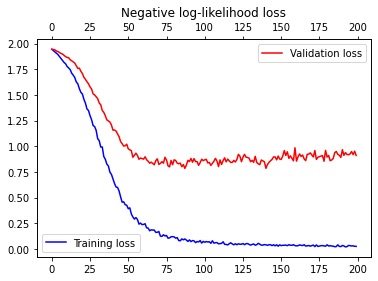

In [79]:
plt.plot(train_loss_hist, 'b', label='Training loss')
plt.legend(loc='lower left')
plt.twiny()
plt.plot(val_loss_hist, 'r', label='Validation loss')
plt.legend(loc='upper right')
plt.title('Negative log-likelihood loss')

#### Training and Validation Accuracies

Text(0.5, 1.0, 'Accuracy')

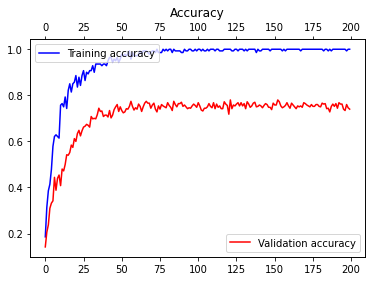

In [80]:
plt.plot(train_acc_hist, 'b', label='Training accuracy')
plt.legend(loc='upper left')
plt.twiny()
plt.plot(val_acc_hist, 'r', label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

#### Test Statistics

In [81]:
model.eval()
pred = model(data).argmax(dim=1)
y_pred_test = pred[data.test_mask].detach().cpu().numpy()
y_true_test = data.y[data.test_mask].detach().cpu().numpy()

In [82]:
from sklearn.metrics import precision_recall_fscore_support
test_acc = accuracy_score(y_true_test, y_pred_test)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_test, y_pred_test, average='macro')
print('Test accuracy: ', test_acc)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 score: ', f1_score)


Test accuracy:  0.778
Precision:  0.7547633541953855
Recall:  0.7974332358312759
F1 score:  0.770510208170877


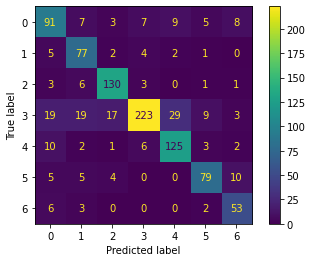

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true_test, y_pred_test, labels=np.unique(y_pred_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_pred_test))
disp.plot()
plt.show()

#### Tutorial list
https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html

https://medium.com/mlearning-ai/ultimate-guide-to-graph-neural-networks-1-cora-dataset-37338c04fe6f

https://neptune.ai/blog/pytorch-loss-functions